In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import defaultdict
from nltk import ngrams
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Magda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Magda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Magda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Magda\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Load the tweets file
tweets_df = pd.read_csv('tweets.csv')

In [4]:
# Load the CSV files for Swahili stopwords and slang
swahili_stopwords_df = pd.read_csv('Common Swahili Stop-words.csv')
swahili_slang_df = pd.read_csv('Common Swahili Slangs.csv')

In [5]:
# Preview the first 3 columns of the tweets file.
tweets_df.head(3)

,link,text,date,no_of_likes,no_of_comments
0,https://twitter.com/KennedyMuling94/status/181...,#OccupyParliament meant the power is back to t...,"Jul 21, 2024 · 5:02 PM UTC",0,0
1,https://twitter.com/KennedyMuling94/status/181...,#OccupyParliament meant the power is back to t...,"Jul 21, 2024 · 4:54 PM UTC",0,0
2,https://twitter.com/KennedyMuling94/status/181...,#OccupyParliament meant the power is back to t...,"Jul 21, 2024 · 4:53 PM UTC",0,0


The dataset consists of tweets, with each row containing information about an individual tweet. 

The columns include:

**link:** The URL to the specific tweet.

**text:** The content of the tweet.

**date:** The timestamp of when the tweet was posted, including the date and time.

**no_of_likes:** The number of likes the tweet received.

**no_of_comments:** The number of comments the tweet received.

In [6]:
# View the columns
tweets_df.columns

Index(['link', 'text', 'date', 'no_of_likes', 'no_of_comments'], dtype='object')

In [7]:
# Copy the data frane
original_copy = tweets_df.copy()

In [8]:
# Drop the columns that will not be needed for this analysis
tweets_df.drop(columns=['link', 'no_of_likes', 'no_of_comments'], inplace=True)

In [9]:
# Check if the columns have been dropped
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15265 entries, 0 to 15264
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15255 non-null  object
 1   date    15265 non-null  object
dtypes: object(2)
memory usage: 238.6+ KB


In [10]:
# Check for duplicates and drop them.
tweets_df.drop_duplicates(inplace=True)

In [11]:
# Check if the duplicates have been dropped
tweets_df

,text,date
0,#OccupyParliament meant the power is back to t...,"Jul 21, 2024 · 5:02 PM UTC"
1,#OccupyParliament meant the power is back to t...,"Jul 21, 2024 · 4:54 PM UTC"
2,#OccupyParliament meant the power is back to t...,"Jul 21, 2024 · 4:53 PM UTC"
3,#OccupyParliament meant the power is back to t...,"Jul 21, 2024 · 4:52 PM UTC"
4,#OccupyParliament meant the power is back to t...,"Jul 21, 2024 · 4:50 PM UTC"
...,...,...
15253,Get eid of the new funding model completely if...,"Jul 24, 2024 · 5:40 AM UTC"
15254,When people think they don't have a say in gov...,"Jul 24, 2024 · 5:39 AM UTC"
15255,US Secret Service Director resigns within 24hr...,"Jul 24, 2024 · 5:39 AM UTC"
15256,The goal of The Butcher was to just win 2022 e...,"Jul 24, 2024 · 5:39 AM UTC"


This dataset contains a series of tweets with two columns:

text: The content of each tweet.

date: The timestamp of when each tweet was posted.

**Key observations:**

The dataset includes 13,802 rows, indicating a large collection of tweets.

The tweets span multiple days, starting from July 21, 2024, and continuing at least until July 24, 2024.

The content of the tweets varies, with some including hashtags like #OccupyParliament and #RUTOMUSTGO. These suggest that the tweets may be related to social or political movements, possibly in response to specific events or decisions.

Some tweets appear to be part of a continuous stream with minimal time differences between them, such as those between 4:50 PM and 5:02 PM on July 21, 2024.

In [12]:
# View the swahili stopwords that will be used for the analysis
swahili_stopwords_df

,StopWords
0,na
1,lakini
2,ingawa
3,ingawaje
4,kwa
...,...
250,nini
251,hasa
252,huu
253,zako


In [13]:
# View the swahili_slang words 
swahili_slang_df

,Slang,Meaning,Meaning1,Meaning2,Meaning3
0,manzi,msichana,NaN,NaN,NaN
1,slay,msichana,NaN,NaN,NaN
2,queen,msichana,NaN,NaN,NaN
3,mshi,msichana,NaN,NaN,NaN
4,chick,msichana,NaN,NaN,NaN
...,...,...,...,...,...
182,arv,dawa za kufubaza virusi vya ukimwi,NaN,NaN,NaN
183,arvs,dawa za kufubaza virusi vya ukimwi,NaN,NaN,NaN
184,tunacorona,tuna corona,NaN,NaN,NaN
185,lais,raisi,NaN,NaN,NaN


In [14]:
# Convert the stopwords and slang words to sets
swahili_stopwords = set(swahili_stopwords_df['StopWords'].tolist())
swahili_slang = set(swahili_slang_df['Slang'].tolist())

In [15]:
# Define stopwords including English, Swahili, and Swahili slang
stop_words = set(stopwords.words('english')).union(swahili_stopwords).union(swahili_slang)

In [16]:
# Function to clean the text
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # Remove @ and # characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text


In [17]:
# Function to preprocess the text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    swahili_stop_words = set (swahili_stopwords.words('swahili'))
    swahili_slang = set (swahili_slang.words('slang'))
    tokens = [word for word in tokens if word not in stop_words]
    stop_words = set(stopwords.words('english')).union(swahili_stop_words, swahili_slang)
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)


In [18]:
# Function to clean the text
def clean_text(text):
    if isinstance(text, str):  # Check if text is a string
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
        text = re.sub(r'\@\w+|\#','', text)  # Remove @ and # characters
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        return text
    else:
        return ''  # Return an empty string if text is not a string

In [19]:
# Clean the text column
tweets_df['cleaned_text'] = tweets_df['text'].apply(clean_text)

In [20]:
tweets_df

,text,date,cleaned_text
0,#OccupyParliament meant the power is back to t...,"Jul 21, 2024 · 5:02 PM UTC",occupyparliament meant the power is back to th...
1,#OccupyParliament meant the power is back to t...,"Jul 21, 2024 · 4:54 PM UTC",occupyparliament meant the power is back to th...
2,#OccupyParliament meant the power is back to t...,"Jul 21, 2024 · 4:53 PM UTC",occupyparliament meant the power is back to th...
3,#OccupyParliament meant the power is back to t...,"Jul 21, 2024 · 4:52 PM UTC",occupyparliament meant the power is back to th...
4,#OccupyParliament meant the power is back to t...,"Jul 21, 2024 · 4:50 PM UTC",occupyparliament meant the power is back to th...
...,...,...,...
15253,Get eid of the new funding model completely if...,"Jul 24, 2024 · 5:40 AM UTC",get eid of the new funding model completely if...
15254,When people think they don't have a say in gov...,"Jul 24, 2024 · 5:39 AM UTC",when people think they dont have a say in gove...
15255,US Secret Service Director resigns within 24hr...,"Jul 24, 2024 · 5:39 AM UTC",us secret service director resigns within hrs ...
15256,The goal of The Butcher was to just win 2022 e...,"Jul 24, 2024 · 5:39 AM UTC",the goal of the butcher was to just win elect...


In [21]:
tweets_df.drop(columns=['text'], inplace=True)

In [22]:
tweets_df

,date,cleaned_text
0,"Jul 21, 2024 · 5:02 PM UTC",occupyparliament meant the power is back to th...
1,"Jul 21, 2024 · 4:54 PM UTC",occupyparliament meant the power is back to th...
2,"Jul 21, 2024 · 4:53 PM UTC",occupyparliament meant the power is back to th...
3,"Jul 21, 2024 · 4:52 PM UTC",occupyparliament meant the power is back to th...
4,"Jul 21, 2024 · 4:50 PM UTC",occupyparliament meant the power is back to th...
...,...,...
15253,"Jul 24, 2024 · 5:40 AM UTC",get eid of the new funding model completely if...
15254,"Jul 24, 2024 · 5:39 AM UTC",when people think they dont have a say in gove...
15255,"Jul 24, 2024 · 5:39 AM UTC",us secret service director resigns within hrs ...
15256,"Jul 24, 2024 · 5:39 AM UTC",the goal of the butcher was to just win elect...


In [23]:
# Function to preprocess the text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in swahili_slang] # Iterate over 'tokens' to remove swahili slang
    tokens = [word for word in tokens if word not in swahili_stopwords] # Iterate over 'tokens' to remove swahili stop words
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens) # Return the single preprocessed text

In [24]:
# Preprocess the text column
tweets_df['preprocessed_text'] = tweets_df['cleaned_text'].apply(preprocess_text)

In [25]:
# Display the cleaned and preprocessed data
cleaned_df = tweets_df[['cleaned_text', 'preprocessed_text', 'date']]
cleaned_df

,cleaned_text,preprocessed_text,date
0,occupyparliament meant the power is back to th...,occupyparliament meant power back people keep ...,"Jul 21, 2024 · 5:02 PM UTC"
1,occupyparliament meant the power is back to th...,occupyparliament meant power back people keep ...,"Jul 21, 2024 · 4:54 PM UTC"
2,occupyparliament meant the power is back to th...,occupyparliament meant power back people keep ...,"Jul 21, 2024 · 4:53 PM UTC"
3,occupyparliament meant the power is back to th...,occupyparliament meant power back people keep ...,"Jul 21, 2024 · 4:52 PM UTC"
4,occupyparliament meant the power is back to th...,occupyparliament meant power back people keep ...,"Jul 21, 2024 · 4:50 PM UTC"
...,...,...,...
15253,get eid of the new funding model completely if...,get eid new funding model completely want u st...,"Jul 24, 2024 · 5:40 AM UTC"
15254,when people think they dont have a say in gove...,people think dont say government spark revolut...,"Jul 24, 2024 · 5:39 AM UTC"
15255,us secret service director resigns within hrs ...,u secret service director resigns within hr co...,"Jul 24, 2024 · 5:39 AM UTC"
15256,the goal of the butcher was to just win elect...,goal butcher win election called president tha...,"Jul 24, 2024 · 5:39 AM UTC"


In [26]:
# Save the DataFrame to a CSV file
cleaned_df.to_csv('cleaned_data.csv', index=False)

In [27]:
data = pd.read_csv('cleaned_data.csv')

In [28]:
data

,cleaned_text,preprocessed_text,date
0,occupyparliament meant the power is back to th...,occupyparliament meant power back people keep ...,"Jul 21, 2024 · 5:02 PM UTC"
1,occupyparliament meant the power is back to th...,occupyparliament meant power back people keep ...,"Jul 21, 2024 · 4:54 PM UTC"
2,occupyparliament meant the power is back to th...,occupyparliament meant power back people keep ...,"Jul 21, 2024 · 4:53 PM UTC"
3,occupyparliament meant the power is back to th...,occupyparliament meant power back people keep ...,"Jul 21, 2024 · 4:52 PM UTC"
4,occupyparliament meant the power is back to th...,occupyparliament meant power back people keep ...,"Jul 21, 2024 · 4:50 PM UTC"
...,...,...,...
13797,get eid of the new funding model completely if...,get eid new funding model completely want u st...,"Jul 24, 2024 · 5:40 AM UTC"
13798,when people think they dont have a say in gove...,people think dont say government spark revolut...,"Jul 24, 2024 · 5:39 AM UTC"
13799,us secret service director resigns within hrs ...,u secret service director resigns within hr co...,"Jul 24, 2024 · 5:39 AM UTC"
13800,the goal of the butcher was to just win elect...,goal butcher win election called president tha...,"Jul 24, 2024 · 5:39 AM UTC"


In [29]:
# Initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

In [30]:
# Convert 'preprocessed_text' column to string type
data['preprocessed_text'] = data['preprocessed_text'].astype(str)

In [31]:
# 5. Sentiment Analysis
data['sentiments'] = data['preprocessed_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
data['sentiment_category'] = data['sentiments'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

In [32]:
data.head()

,cleaned_text,preprocessed_text,date,sentiments,sentiment_category
0,occupyparliament meant the power is back to th...,occupyparliament meant power back people keep ...,"Jul 21, 2024 · 5:02 PM UTC",0.0,Neutral
1,occupyparliament meant the power is back to th...,occupyparliament meant power back people keep ...,"Jul 21, 2024 · 4:54 PM UTC",0.0,Neutral
2,occupyparliament meant the power is back to th...,occupyparliament meant power back people keep ...,"Jul 21, 2024 · 4:53 PM UTC",0.0,Neutral
3,occupyparliament meant the power is back to th...,occupyparliament meant power back people keep ...,"Jul 21, 2024 · 4:52 PM UTC",0.0,Neutral
4,occupyparliament meant the power is back to th...,occupyparliament meant power back people keep ...,"Jul 21, 2024 · 4:50 PM UTC",0.0,Neutral


*   -1.0 represents very negative sentiment.
*   0.0 represents neutral sentiment.
*   1.0 represents very positive sentiment.









In [33]:
data['sentiment_category'].head(20)

0      Neutral
1      Neutral
2      Neutral
3      Neutral
4      Neutral
5      Neutral
6      Neutral
7      Neutral
8      Neutral
9      Neutral
10     Neutral
11    Positive
12     Neutral
13    Negative
14     Neutral
15    Positive
16     Neutral
17     Neutral
18    Negative
19    Positive
Name: sentiment_category, dtype: object

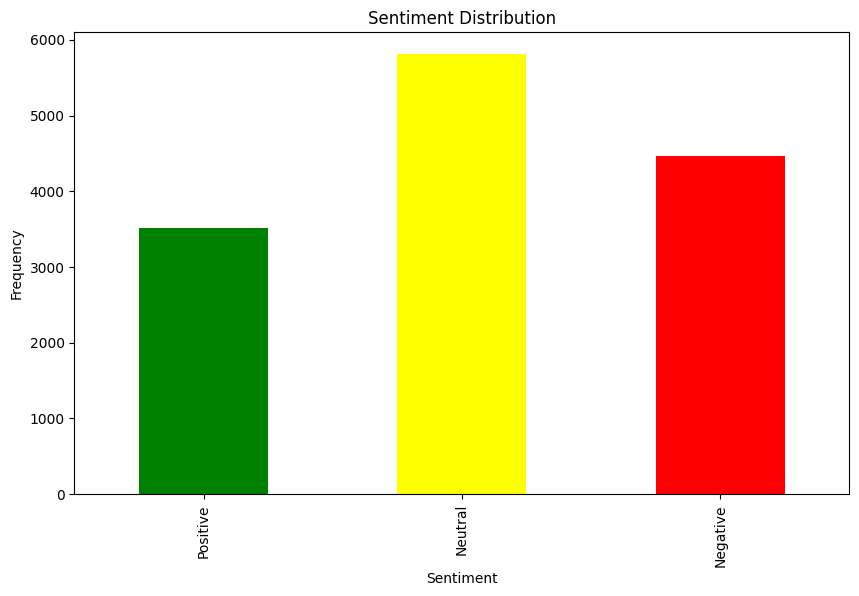

In [34]:
# 6. Visualization of sentiments
sentiments = ['Positive', 'Neutral', 'Negative']

# Plotting the sentiment distribution
plt.figure(figsize=(10, 6))

# Reorder the sentiment categories before plotting
data['sentiment_category'] = pd.Categorical(data['sentiment_category'], categories=sentiments, ordered=True)

# Plot the bar chart
data['sentiment_category'].value_counts().reindex(sentiments).plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')

# Set the x-ticks to match the order
plt.xticks(range(len(sentiments)), sentiments)
plt.show()

The bar chart shows the distribution of sentiments (Neutral, Negative, and Positive) within the dataset. Here’s a detailed interpretation:

**Positive Sentiment:**


*   Positive sentiment is the least frequent, with a frequency of about 3,000. This indicates that positive emotions and favorable opinions are less common in the dataset compared to neutral and negative sentiments.


**Neutral Sentiment:**

*  The majority of the data points have a neutral sentiment, with a frequency of over 6,000. This indicates that most of the content in the dataset does not express strong positive or negative emotions.

**Negative Sentiment:**

*   The second most frequent sentiment is negative, with a frequency of around 5,000. This suggests that a significant portion of the data contains negative sentiments, reflecting dissatisfaction, criticism, or negative reactions.






#Wordcloud

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [36]:
# Combine all text data into a single string
text_data = ' '.join(data['preprocessed_text'])

In [37]:
# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

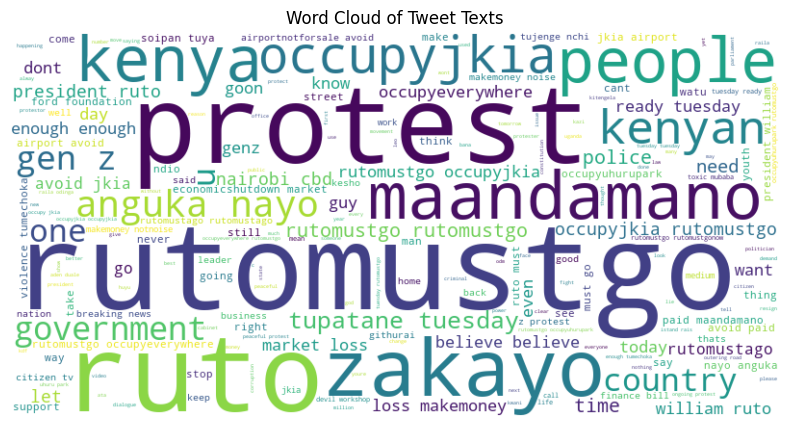

In [38]:
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tweet Texts")
plt.show()

The word cloud visualization reveals the most prominent words in the tweet texts related to the protests.

**"protest":** The most prominent word, indicating that protests are the main topic of discussion.

**"rutomustgo" and "ruto":** These terms are frequently mentioned, suggesting a significant focus on opposition to a person named Ruto.

**"zakayo":** Another frequently mentioned term, potentially a key figure or term related to the protests.

**"occupyjkia":** This term indicates a specific protest or movement focused on the Jomo Kenyatta International Airport (JKIA).

**"kenya" and "kenyan": **These words suggest that the protests and discussions are related to events in Kenya.

**"maandamano":** A Swahili word for protests, reinforcing the focus on protest activities.

**"people":** Indicates the involvement or focus on the people in the protest activities.

**"police":** Suggests discussions about law enforcement in the context of the protests.

**"government":** Indicates that the government is a significant topic in the context of the protests.

***Contextual Words:***

**"occupy":** Related to various locations, suggesting a strategy of occupying key areas.

**"genz" and "youth":** Indicating that younger generations are involved or are a topic of discussion.

**"tuesday":** A specific day that might be significant for the protest activities.

**"time":** Refers to timing, either of events or the urgency of the protest.

**"let", "go", "want", "need":** Words indicating demands or actions related to the protests.

**Sentiment and Actions:**

**"believe", "even", "still":** Reflect sentiment and the state of mind of the participants or observers.

**"avoid", "stop":** Indicate actions or recommendations related to the protests.

Overall, the word cloud highlights a significant amount of protest-related discussion focused on key figures, locations, and actions within Kenya, with prominent involvement of younger generations and calls for specific actions against certain entities.








In [39]:
# Separate texts by sentiment category
positive_texts = ' '.join(data[data['sentiment_category'] == 'Positive']['preprocessed_text'])
neutral_texts = ' '.join(data[data['sentiment_category'] == 'Neutral']['preprocessed_text'])
negative_texts = ' '.join(data[data['sentiment_category'] == 'Negative']['preprocessed_text'])

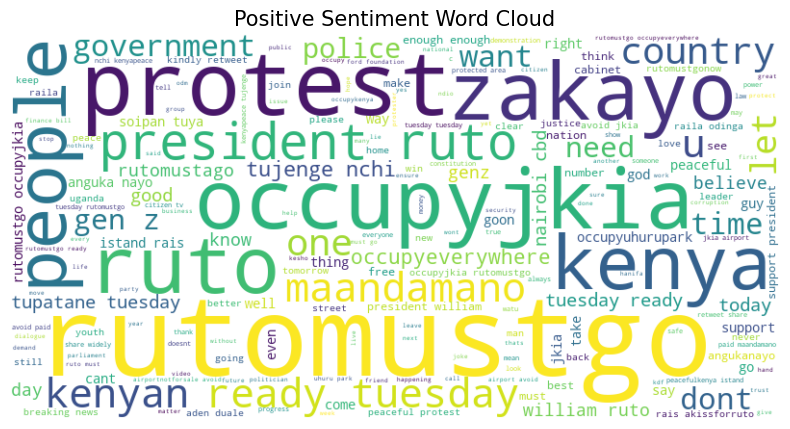

In [40]:
# Function to generate word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=15)
    plt.show()

# Generate word clouds for each sentiment category
generate_wordcloud(positive_texts, 'Positive Sentiment Word Cloud')

The word cloud predominantly conveys a sense of optimism, hope, and unity. The presence of words like "good", "peace", "justice", "believe", "support", and "love" reinforces this positive sentiment.

Key Themes:

Protest and Change: Words like "protest", "occupyjkia", "rutomustgo", "change", and "justice" indicate a strong focus on social and political change.

Unity and Togetherness: Terms like "people", "together", "support", "stand", and "occupyeverywhere" emphasize a sense of collective action and solidarity.

Hope and Optimism: Words like "good", "better", "peace", "hope", and "believe" reflect a positive outlook for the future.

Specific Demands: The frequent appearance of "rutomustgo" and "occupyjkia" suggests targeted demands for political change.

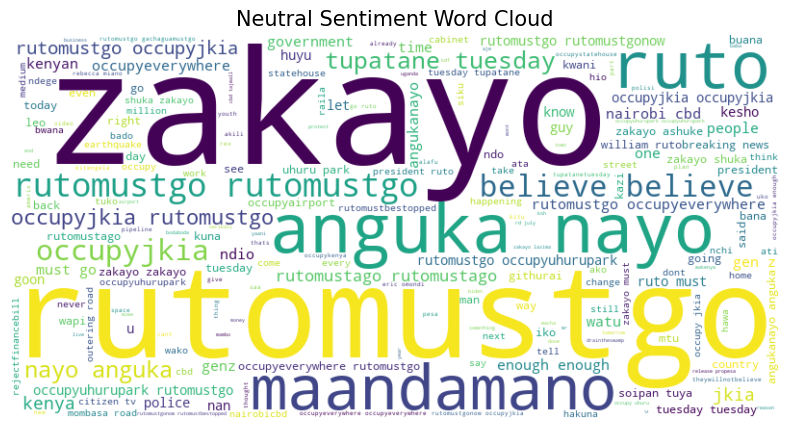

In [41]:
generate_wordcloud(neutral_texts, 'Neutral Sentiment Word Cloud')

Dominant Themes:

Protest and Discontent: Words like "occupyjkia", "rutomustgo", "maandamano" (demonstrations), "government", "president", "tuko" (we are), and "anguka nayo" (fall down) are prominent, indicating a strong focus on protest, dissent, and dissatisfaction with the government.

Time and Place: Words like "tuesday", "today", "now", "time", "nairobi", "cbd", "kenya" suggest a focus on current events and specific locations.

People and Unity: Terms like "people", "together", "one", "we", and "occupyeverywhere" imply a sense of collective action and unity among protesters.

Specific Demands: The repeated phrase "rutomustgo" highlights a central demand of the protests.

Overall Sentiment:

While labeled as "neutral," the word cloud leans towards a negative sentiment due to the prevalence of words associated with protest, discontent, and criticism of the government. However, the absence of overtly negative or aggressive language suggests a more measured tone compared to potentially negative or positive sentiment word clouds.

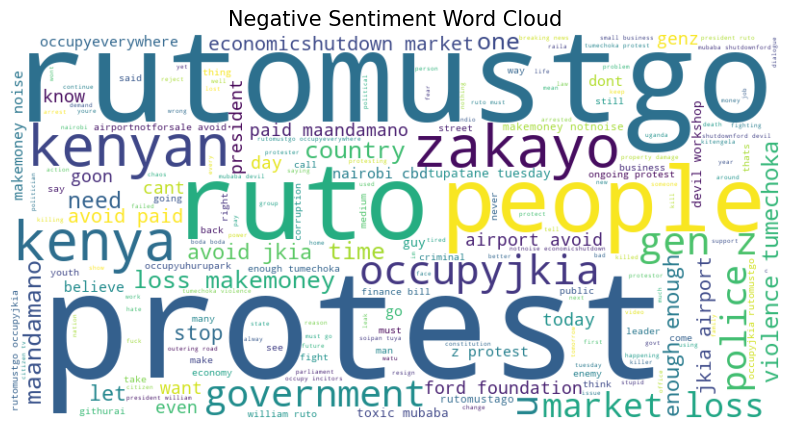

In [42]:
generate_wordcloud(negative_texts, 'Negative Sentiment Word Cloud')

Dominant Themes:

The word cloud overwhelmingly reflects a negative sentiment, centered around discontent, protest, and economic hardship.

Protest and Discontent: Words like "maandamano" (protests), "occupyjkia", "rutomustgo", "tumechoka" (we are tired), "fight", "violence", "enough", and "stop" are prominent, indicating a strong sense of frustration and opposition.

Economic Hardship: Terms such as "market loss", "makemoney", "economic shutdown", "loss", "finance bill", and "job" highlight the economic struggles faced by many.

Government Criticism: Words like "government", "president", "corruption", "paid", and "police" suggest a critical view of the government and its policies.

Calls to Action: Phrases like "occupyjkia", "rutomustgo", and "tupatane" (let's meet) emphasize a collective desire for change and mobilization.

Specific Issues:

The prominence of "ruto"  indicate he is a central figure driving the negative sentiment.

The mention of "finance bill" suggests economic policies are a significant point of contention.

Words like "violence", "goon", and "enemy" highlight the perceived threat or aggression associated with the situation.
Overall Sentiment:

The word cloud paints a picture of widespread dissatisfaction, economic hardship, and a strong desire for political change. The tone is largely negative and confrontational, with a clear call to action against perceived injustices.

In [43]:
from collections import Counter
from datetime import datetime

In [44]:
# Convert 'date' to datetime format
data['date'] = pd.to_datetime(data['date'], format='%b %d, %Y · %I:%M %p UTC')

In [45]:
# Define words of interest
words_of_interest = [
    'protest', 'rutomustgo', 'ruto', 'zakayo', 'occupyjkia', 'kenya', 'kenyan',
    'maandamano', 'people', 'police', 'government', 'occupy', 'genz', 'youth',
    'tuesday', 'time', 'let', 'go', 'want', 'need', 'believe', 'even', 'still',
    'avoid', 'stop'
]

# Function to count occurrences of words
def count_words(text, words):
    word_counts = Counter(word for word in text.split() if word in words)
    return dict(word_counts)

# Count occurrences of words for each row
data['word_counts'] = data['preprocessed_text'].apply(lambda x: count_words(x, words_of_interest))

In [46]:
# Create a DataFrame from the word counts
word_counts_df = pd.DataFrame(data['word_counts'].tolist(), index=data.index).fillna(0)

# Merge the word counts DataFrame with the original data
data = pd.concat([data, word_counts_df], axis=1)

In [47]:
# Aggregate data by date with explicit numeric_only parameter
daily_word_counts = data.groupby(data['date'].dt.date).sum(numeric_only=True).reset_index()

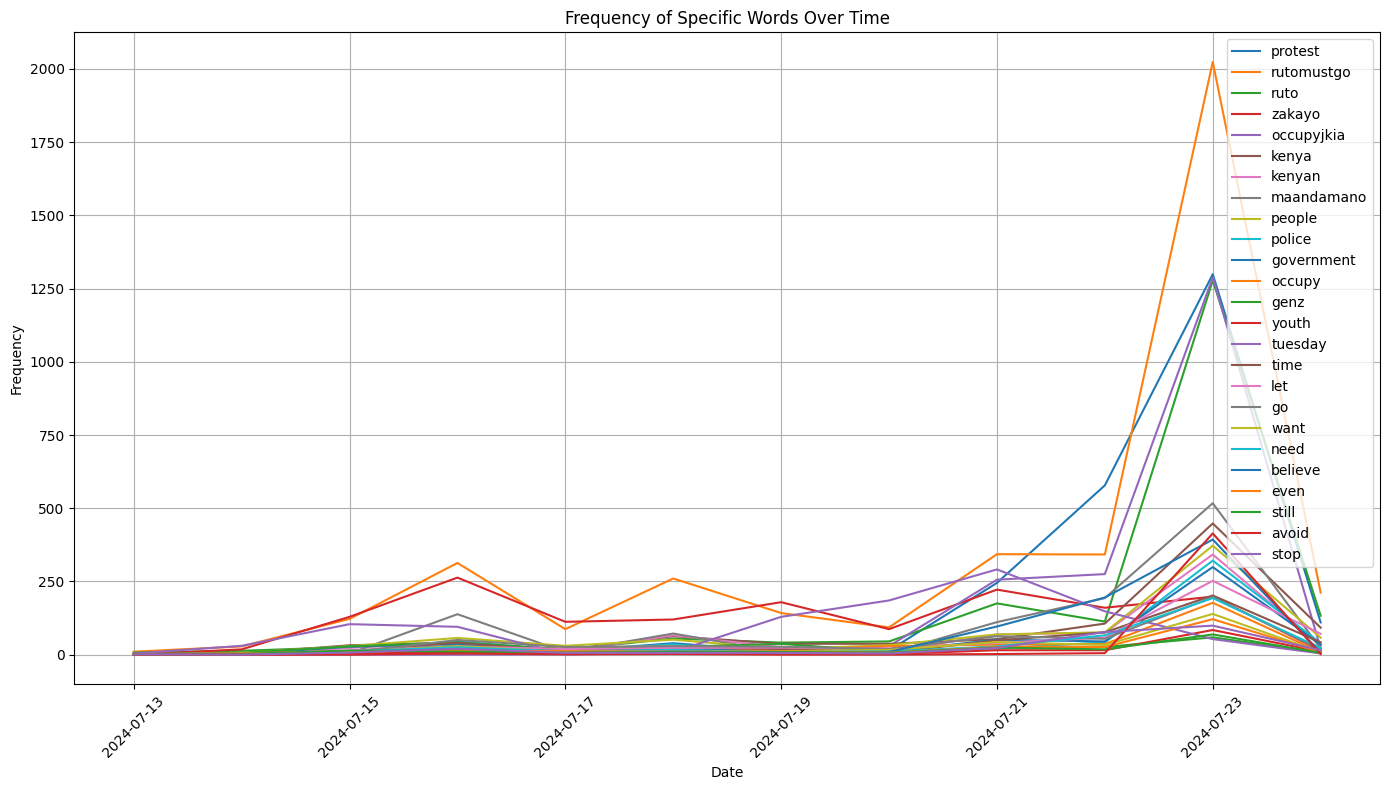

In [48]:
# Plotting the data
plt.figure(figsize=(14, 8))

for word in words_of_interest:
    if word in daily_word_counts.columns:
        plt.plot(daily_word_counts['date'], daily_word_counts[word], label=word)

plt.title('Frequency of Specific Words Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The line plot visualizes the frequency of specific words over a period from approximately July 13th to July 23rd, 2024.

Key Findings

Dominant Words: The words "protest," "rutomustgo," "ruto," and "occupyjkia" exhibit significantly higher frequencies compared to other words, suggesting they were central topics during this period.

Fluctuating Frequencies: Most words exhibit fluctuations in frequency over time, indicating varying levels of usage.

Peak Usage: Some words, like "protest" and "rutomustgo," experienced sharp peaks, suggesting specific events or trends drove their increased usage.

Correlated Trends: Certain words, such as "rutomustgo" and "occupyjkia," tend to move together, indicating a potential relationship or shared context.

Emerging Trends: Words like "genz" and "youth" show an upward trend, suggesting growing relevance or participation of younger demographics.

In [49]:
# Aggregate sentiment scores by date
daily_sentiments = data.groupby(data['date'].dt.date)['sentiments'].mean().reset_index()

# Check the resulting DataFrame structure
print(daily_sentiments.head())

         date  sentiments
0  2024-07-13   -0.013648
1  2024-07-14    0.020110
2  2024-07-15   -0.021281
3  2024-07-16   -0.047621
4  2024-07-17   -0.011833


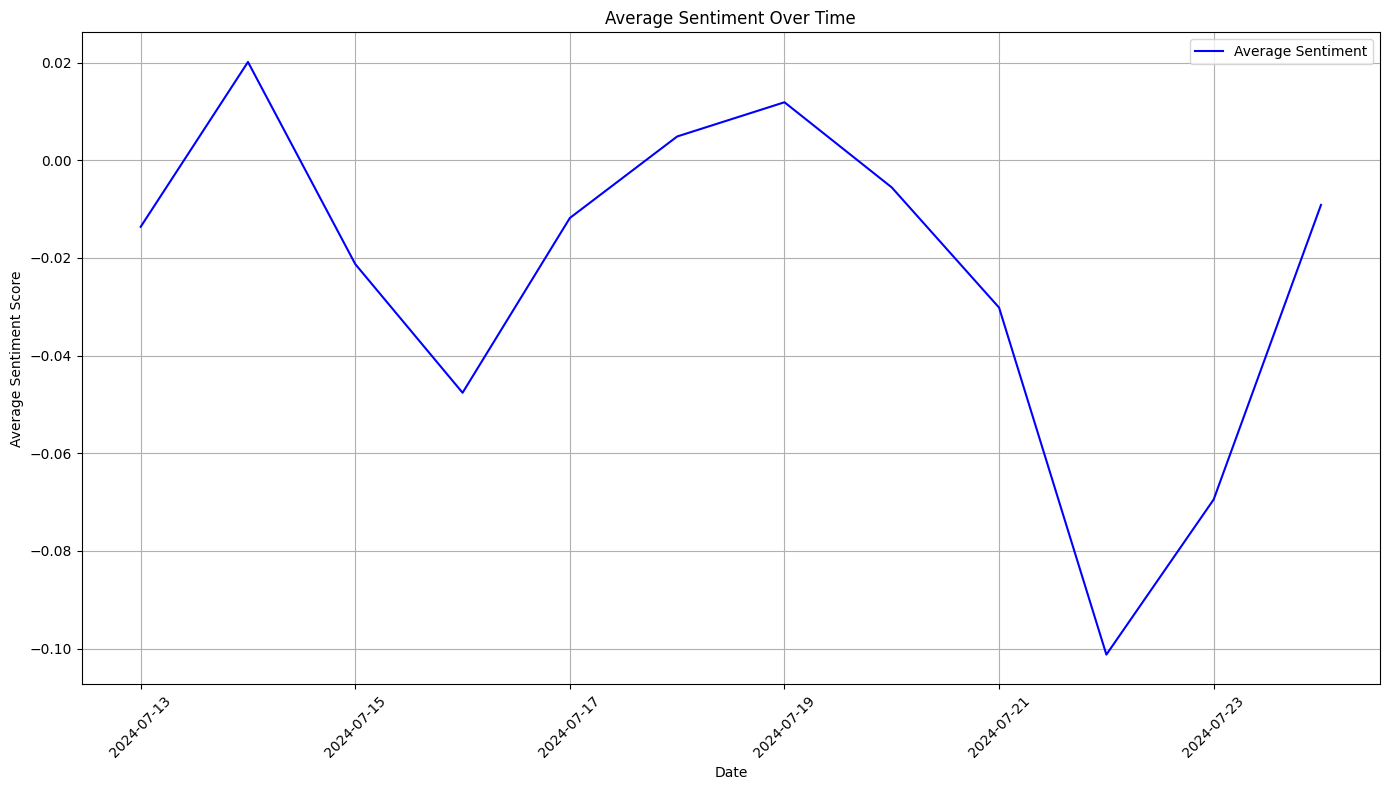

In [50]:
# Plotting the sentiment scores over time
plt.figure(figsize=(14, 8))

plt.plot(daily_sentiments['date'], daily_sentiments['sentiments'], label='Average Sentiment', color='blue')

plt.title('Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The line plot illustrates the fluctuation of average sentiment over a specific period, ranging from approximately July 13th to July 23rd, 2024. The sentiment score appears to be a numerical value, with positive values indicating more positive sentiment and negative values representing more negative sentiment.

Key Observations:

Fluctuating Sentiment: The average sentiment score exhibits significant fluctuations over the analyzed period, indicating shifts in overall sentiment.

Negative Bias: The majority of the data points lie below the zero line, suggesting a generally negative sentiment during this time.

Extreme Points: There are instances of both highly positive and highly negative sentiment scores, indicating periods of strong emotional reactions.

General Trend: While there are fluctuations, there doesn't seem to be a clear overall upward or downward trend in sentiment.

In [51]:
# Aggregate counts of sentiment categories by date
daily_sentiment_counts = data.groupby([data['date'].dt.date, 'sentiment_category']).size().unstack(fill_value=0).reset_index()

# Check the resulting DataFrame structure
print(daily_sentiment_counts.head())

sentiment_category        date  Positive  Neutral  Negative
0                   2024-07-13         6        9         8
1                   2024-07-14        45       24        29
2                   2024-07-15       141      204       129
3                   2024-07-16       222      484       262
4                   2024-07-17       118      236       123


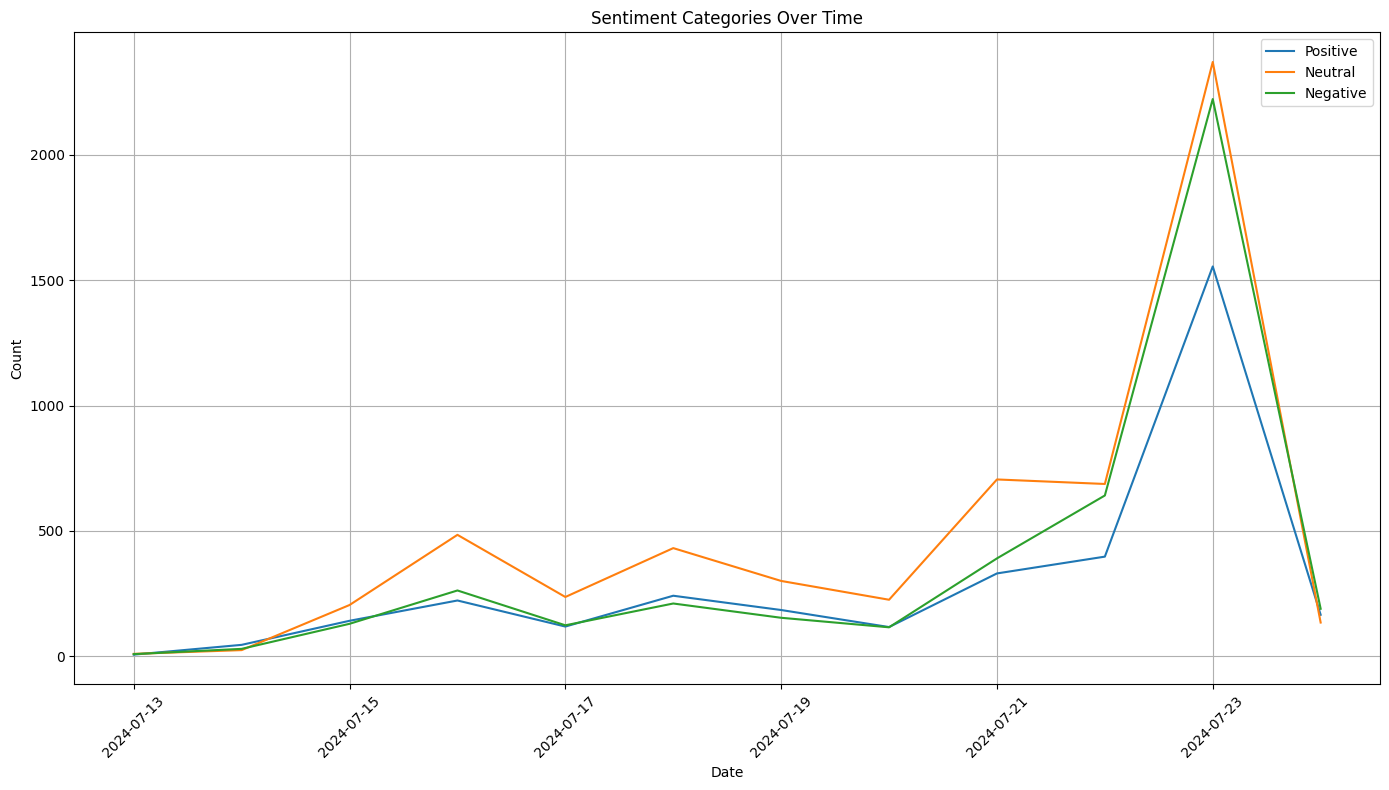

In [52]:
# Plotting the sentiment categories over time
plt.figure(figsize=(14, 8))

# Plot each sentiment category
for sentiment in ['Positive', 'Neutral', 'Negative']:
    if sentiment in daily_sentiment_counts.columns:
        plt.plot(daily_sentiment_counts['date'], daily_sentiment_counts[sentiment], label=sentiment)

plt.title('Sentiment Categories Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The graph illustrates the distribution of sentiment categories (positive, neutral, and negative) over a specific time period, ranging from July 13th to July 23rd, 2024. The y-axis represents the count of sentiments, while the x-axis shows the date.

Key Findings:

Dominance of Negative Sentiment: The "Negative" line consistently occupies the highest position on the graph, indicating that negative sentiment was the most prevalent throughout the analyzed period.

Fluctuating Trends: All three sentiment categories exhibit fluctuations over time, with peaks and troughs in their respective counts.

Sharp Increase Around July 22nd: A notable spike is observed in all sentiment categories, particularly negative, around July 22nd, suggesting a significant event or trend impacted sentiment during this time.

Relative Proportions: The relative proportions of positive, neutral, and negative sentiments vary over time. While negative sentiment is dominant, there are periods where neutral or even positive sentiment increases.

# Topic Modeling

In [53]:
# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=['english', 'swahili_stopwords', 'swahili_slang'])
doc_term_matrix = vectorizer.fit_transform(data['preprocessed_text'])

In [54]:
# Initialize LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [55]:
# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 1:
zakayo president kenya ruto let occupyuhurupark protest raila peace rutos
Topic 2:
rutomustgo believe occupyjkia people occupyeverywhere zakayo protest kenyan ruto one
Topic 3:
ruto tuesday rutomustgo nayo anguka rutomustago tupatane occupyjkia ready enough
Topic 4:
protest occupyjkia loss road nairobi economicshutdown market makemoney cbd economic
Topic 5:
protest jkia maandamano avoid paid enough airport government police area


In [56]:
# N-grams Analysis
# Function to generate n-grams
def generate_ngrams(clean_text, n):
    words = clean_text.split()
    return list(ngrams(words, n))

In [57]:
# Bigrams
freq_dict = defaultdict(int)
for sent in data["preprocessed_text"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1

In [58]:
fd_sorted_bigrams = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
fd_sorted_bigrams.columns = ["word", "wordcount"]

In [59]:
# Plot the top 25 most frequent bigrams
def horizontal_bar_chart(data, color, title):
    data.plot(kind='barh', x='word', y='wordcount', color=color)
    plt.xlabel('Word Count')
    plt.ylabel('Bigrams')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
    plt.show()


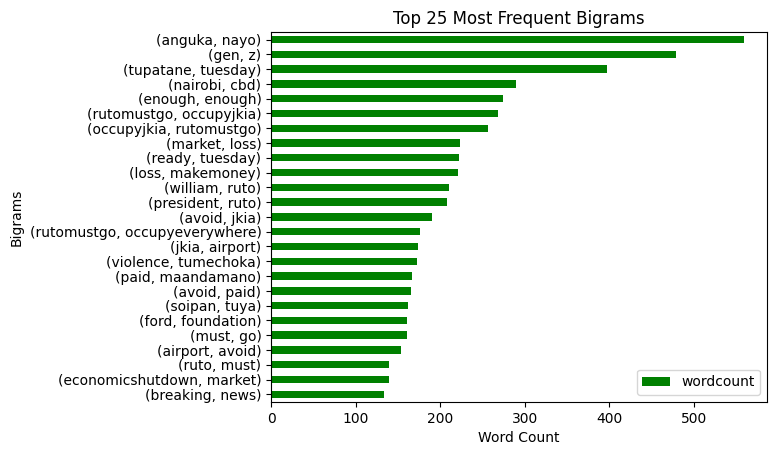

In [60]:
horizontal_bar_chart(fd_sorted_bigrams.head(25), 'green', 'Top 25 Most Frequent Bigrams')

The bar chart shows the top 25 most frequent bigrams (two-word combinations) in the dataset. Here’s a detailed interpretation:

**High Frequency Bigrams:**


*  The most frequent bigram is "(anguka, nayo)" with around 600 occurrences. This suggests that this phrase is very commonly discussed in the dataset.
*   Other high-frequency bigrams include "(gen, z)", "(tupatane, tuesday)", and "(occupyjkia, rutomustgo)", each with significant counts, indicating these terms are prevalent in the discussions.

**Protest and Movement Keywords:**


*   Bigrams like "(tupatane, tuesday)" and "(occupyjkia, rutomustgo)" suggest organized protest movements and specific days for action.
*   "(rutomustgo, occupyjkia)" and "(rutomustgo, occupyeverywhere)" indicate coordinated efforts under the banner "Ruto Must Go," focusing on occupying specific places like JKIA (Jomo Kenyatta International Airport).
Political Figures and Contexts:


*   Bigrams such as "(william, ruto)", "(president, ruto)", and "(president, william)" point to discussions about President William Ruto.
*   "(soipan, tuya)" is another political figure frequently mentioned.
Economic and Social Issues:


*   "(market, loss)" and "(loss, makemoney)" indicate ongoing discussions about economic issues and financial losses.
*   "(violence, tumechoka)" (translated to "violence, we are tired") reflects social discontent and fatigue with ongoing violence.

**Location-Specific Mentions:**


*   "(nairobi, cbd)" and "(jkia, airport)" highlight specific locations frequently mentioned in the dataset.

**Coordinated Messaging and Reactions:**


*   Repetitive bigrams like "(anguka, nayo)", "(tupatane, tuesday)", and "(ready, tuesday)" suggest coordinated messaging around specific events or actions.
*  "(breaking, news)" implies frequent mentions of recent or significant events.




In [61]:
# Trigrams
freq_dict = defaultdict(int)
for sent in data["preprocessed_text"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1

In [62]:
fd_sorted_trigrams = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
fd_sorted_trigrams.columns = ["word", "wordcount"]

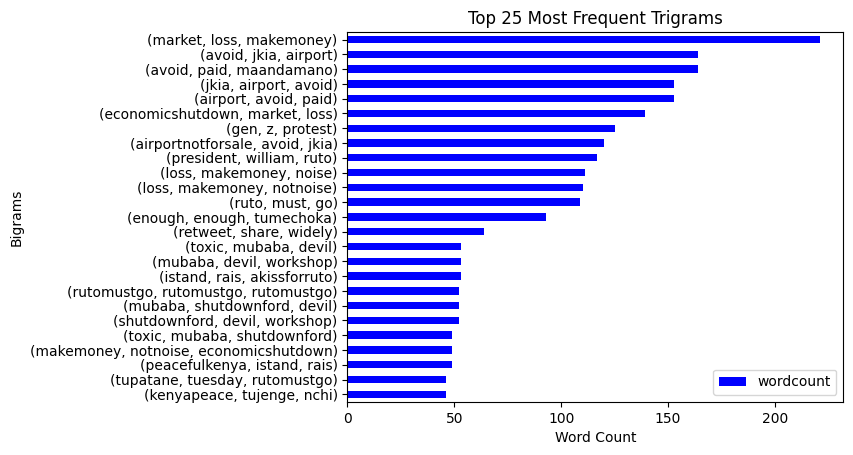

In [63]:
# Plot the top 25 most frequent trigrams
horizontal_bar_chart(fd_sorted_trigrams.head(25), 'blue', 'Top 25 Most Frequent Trigrams')


The bar chart shows the top 25 most frequent trigrams (three-word combinations) in the dataset. Here’s a detailed interpretation:

**Interpretation**
**High Frequency Trigrams:**


1. The most frequent trigram is "(market, loss, makemoney)" with over 200 occurrences. This suggests that discussions about market losses and making money are prevalent in the dataset.
2. Other high-frequency trigrams include "(avoid, jkia, airport)", "(avoid, paid, maandamano)", and "(jkia, airport, avoid)", each with over 150 occurrences. This indicates a significant amount of discussion around avoiding the JKIA airport and associated events.

**Economic and Political Discussions:**

Trigrams like "(economicshutdown, market, loss)", "(president, william, ruto)", and "(gen, z, protest)" point to discussions about economic shutdowns, market losses, the president (William Ruto), and protests involving Generation Z.

**Specific Issues and Movements:**

1.  The presence of trigrams like "(rutomustgo, ruto, must, go)" and "(retweet, share, widely)" suggests organized movements and calls to action, likely against political figures or policies.
2.  "(airportnotforsale, avoid, jkia)" indicates a specific campaign or protest related to the sale of an airport.
Sentiment and Reaction:


*   Trigrams such as "(enough, enough, tumechoka)" (translated to "enough, enough, we are tired") and "(kindly, retweet, share)" reflect a collective sentiment of exhaustion and calls for widespread sharing and support.
Repeated and Coordinated Messaging:
*   Repeated trigrams like "(rutomustgo, rutomustgo, rutomustgo)" and "(toxic, mubaba, devil)" suggest coordinated messaging and repetitive emphasis on certain themes.




